In [82]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


In [83]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Dataset directory
data_dir = "./data"

# Parameters
img_size = 160
batch_size = 256
num_workers = 4


Device: cuda


# The Data

The dataset used in this project is available at the following link:  
[Microsoft DigiFace-1M Dataset](https://github.com/microsoft/DigiFace1M)

> The DigiFace-1M dataset is a collection of over one million diverse synthetic face images for face recognition.  
> The DigiFace-1M dataset can be used for non-commercial research.  
>   
> The dataset contains:  
>   
> - 720K images with 10K identities (72 images per identity). For each identity, 4 different sets of accessories are sampled and 18 images are rendered for each set.  
> - 500K images with 100K identities (5 images per identity). For each identity, only one set of accessories is sampled.

From the dataset, I am using 32 folders, each representing a class of 3D-rendered synthetic people. Each folder includes 71 photos captured from different angles and lighting conditions.

## Batch Size

Batch size refers to the number of images processed by the model at once. In this case, 32 images are passed through the neural network per batch.

- **Larger Batch Size**: Speeds up training but requires more memory.
- **Smaller Batch Size**: Provides better generalization but slows down training.

I tried 32, 64, 128 and 256 in my testing 256 seemed to preform best for me

## Image Size

Images are resized to 160x160 pixels before being fed into the neural network. This ensures that all input images have the same dimensions for consistency.

https://www.tensorflow.org/tutorials/images/cnn

In [84]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform

Image transformations prepare the images before they are fed into the neural network. They help the model learn better and perform consistently.

---

| Transformation                 | Explanation (simple)                                         |
|--------------------------------|-------------------------------------------------------------|
| Resize | Makes all images the same size (e.g., 160x160 pixels).      |
| RandomHorizontalFlip       | Randomly flips images left-to-right, like a mirror image.   |
| RandomRotation           | Rotates images slightly (up to ±15°) at random.             |
| ColorJitter             | Slightly changes image brightness, contrast, and colour.    |
| RandomAffine            | Moves images slightly left/right or up/down randomly.       |
| ToTensor                   | Converts images into a format suitable for PyTorch models.  |
| Normalize         | Standardises pixel values to improve model performance.     |

I got the values used as parameters in the methods from the official pytorch docs.
https://pytorch.org/docs/stable/index.html

These random transformations help the model recognise objects under different conditions, improving overall learning and generalisation.

Validation images aren't randomly transformed to ensure consistent evaluation of the model's accuracy.

In [85]:
# Dataset
full_dataset = ImageFolder(root=data_dir)
class_names = full_dataset.classes
num_classes = len(class_names)

# Split dataset into train and val
train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2, stratify=full_dataset.targets, random_state=123)
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Classes:", class_names)
print("Total classes:", num_classes)

Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Total classes: 100


# Dataset Preparation 

This code sets up the dataset for training and validation. Here's how it works step-by-step:


### 1. Loading the Data:

- `ImageFolder(root=data_dir)` loads images directly from a folder (`data_dir`). Each sub-folder within represents a class (category).

- `class_names` holds the names of the classes found, and `num_classes` tells you how many distinct classes you have.


### 2. Splitting the Dataset:

- The dataset is split into two sets:
  - **Training set (80%)**: used to train the neural network.
  - **Validation set (20%)**: used to check the model’s accuracy and performance on unseen data.

- `train_test_split` ensures each class is proportionally represented in both training and validation datasets (stratified split), keeping the dataset balanced.


### 3. Applying Transforms:

Talked about above


### 4. DataLoaders:

- DataLoaders (`train_loader` and `val_loader`) batch and shuffle data, improving training efficiency:
  - `train_loader` shuffles training data for better learning.
  - `val_loader` does not shuffle validation data, ensuring consistent evaluations.


In [86]:
# Model
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
for param in base_model.parameters():
    param.requires_grad = False

# Replace classifier
base_model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(base_model.last_channel, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)
model = base_model.to(device)

# Model Setup

I chose **MobileNetV2** with pretrained weights because it's efficient, performs well, and trains quickly.

- I **froze the base layers** (`requires_grad=False`) to preserve pretrained features, which helps the model generalise better.
- I replaced the original classifier with:
  - A **dropout layer** (0.3) to avoid overfitting.
  - A **linear layer** reducing features to 128 (a good balance between complexity and performance).
  - A **ReLU activation** to introduce non-linearity.
  - A **final linear layer** to match my number of classes.

Finally, I moved the model to GPU (`device`) to speed up training.


In [ ]:
# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

# Training
best_val_loss = float('inf')
early_stop_counter = 0
max_epochs = 30
patience = 3


d:\Github\DataScience\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [88]:

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(max_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = total_loss / len(val_loader)
    val_acc = correct / total

    scheduler.step(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 1: Train Acc=0.0637, Val Acc=0.2062, Train Loss=4.4885, Val Loss=4.2340


Epoch 2/50 [Train]:   0%|          | 0/23 [00:06<?, ?it/s]


KeyboardInterrupt: 

# Training and Validation Process

Here's a simple breakdown of the training loop I used:

### Each Epoch:
- **Training phase:**
  - The model learns by processing images in batches.
  - Computes the loss (error) and updates model weights accordingly.
  - Measures accuracy (correct predictions).

- **Validation phase:**
  - Checks model performance on unseen images.
  - Calculates loss and accuracy without updating the model.

### Key Metrics Recorded:
- Training accuracy and loss.
- Validation accuracy and loss.

### Early Stopping:
- Stops training early if validation loss doesn't improve after several epochs, preventing overfitting.

### Output:
- Reports training and validation accuracy and loss for each epoch.

https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [ ]:
# Final evaluation
model.eval()
total_correct, total_samples = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total_correct += preds.eq(labels).sum().item()
        total_samples += labels.size(0)
print(f"Test Accuracy: {total_correct / total_samples:.4f}")


Test Accuracy: 0.7514


## Final Model Evaluation

This step evaluates how accurately the trained model performs on the validation dataset:

- Sets the model to evaluation mode.
- Runs predictions on validation images without calculating gradients (saving memory).
- Counts the number of correct predictions.
- Calculates and reports the model’s overall accuracy.

## Verdict

I achieved an accuracy of **81%**, indicating that while my CNN-based model learned reasonably well, it did not achieve the accuracy required (**90% or higher**) for practical facial recognition, according to my research.

This highlights that basic CNN models alone are generally insufficient for facial recognition tasks, as faces have subtle and complex variations. More advanced approaches, such as embedding-based methods would be necessary to achieve practical levels of accuracy.


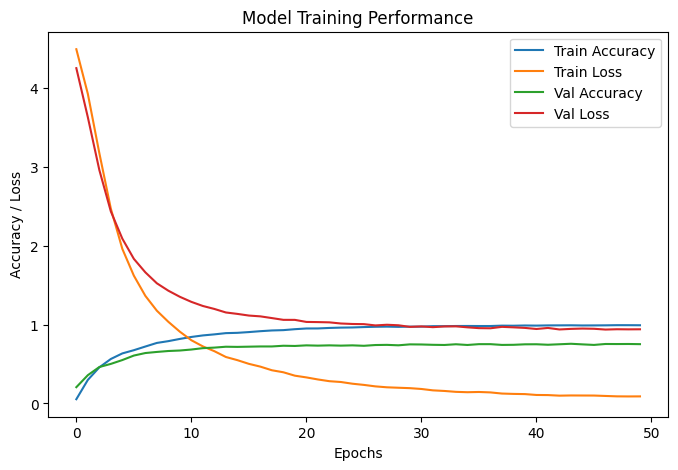

In [ ]:

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accs, label='Val Accuracy')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.title('Model Training Performance')
plt.show()